# 간단한 모델 생성
- XGB
- LGBM
- 'X,Y + 버스 + 지하철' 전처리된 데이터 사용
- 전처리 안 된 feature는 일단 삭제

In [2]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/f2/3d/4f152cf694aec100ab63b4a5547f2dbfbea59ab39d9375c89bed9775e47d/lightgbm-4.4.0-py3-none-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.7 MB/s eta 0:00:0000:0100:01


In [90]:
!pip install joblib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import gc

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import joblib

# 맥에서 글씨 깨짐 방지
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# Data Load

In [2]:
df = pd.read_csv('../data/34_apart_price_mean.csv')

/tmp/ipykernel_656853/3478061192.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/34_apart_price_mean.csv')


In [3]:
df.shape

(1128094, 105)

In [4]:
# 일부 feature 제거 - 기준은 내마음대로

df.drop(['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
         'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
         'k-사용검사일-사용승인일', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)', 'k-전용면적별세대현황(60~85이하)',
         'k-85~135이하', 'k-135초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태',
         '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'], axis=1, inplace=True)

In [5]:
# 추가로 제거가 필요한 feature 제거
df.drop(['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-관리방식', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적',
         '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '시군구 번지', '좌표X,좌표Y', 'index', '역사_ID', '역사명', '위도', '경도',
         '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호', '가장 가까운 버스 정류소명',
         '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표', '가장 가까운 버스 정류장 Y좌표', '동', '구', '호선'], axis=1, inplace=True)

In [6]:
df.drop(['인근 지하철 역 개수', '인근 버스 정류장 개수', '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양',
       '거래량', '건설사 랭킹', '구별 지가지수', '공시지가 평균', '매수우위지수','30년이상50년이하', '구매력지수', '거래활발지수', '매매가격 지수 증감률', '매매 대비 전세가격 비율',
       '아파트 카테고리', '지하철 카테고리','GDP', '구 카테고리', '건설사 카테고리', '가장 가까운 다리와의 거리', '가장 가까운 다리 index', '가장 가까운 다리', '인근 한강다리 개수',
       '인근 다리 개수 1개이상 3개 이하', '학군', '매매가격 지수'],axis = 1, inplace=True)

In [7]:
# 계약월 변수 생성

df['계약월'] = df['계약년월'].astype(str).str[4:].astype(int)

In [8]:
df['계약월_sin'] = np.sin(2 * np.pi * df['계약월'] / 12)

In [9]:
df.drop(['계약월'], axis=1, inplace=True)

In [10]:
df.columns

Index(['전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test',
       '가장 가까운 거리', '가장 가까운 버스 정류장 거리', '계약년', '건물나이', '아파트 평균 가격', '계약월_sin'],
      dtype='object')

# scaling

In [11]:
def scailing(col, scaler_type):
    if scaler_type == 'min_max': scaler = MinMaxScaler()
    else : scaler = StandardScaler()

    return scaler.fit_transform(df[[col]])

cols = ['전용면적', '층', '건축년도', '좌표X', '좌표Y', '가장 가까운 거리',
       '가장 가까운 버스 정류장 거리', '건물나이', '아파트 평균 가격']

for col in cols:
    print(col)
    scaler_type = 'min_max'
    # if col == ['계약월_sin']: scaler_type = 'standard'

    df[[col]] = scailing(col, scaler_type)

전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
가장 가까운 버스 정류장 거리
건물나이
아파트 평균 가격


# 카테고리 변수 처리
- 30년이상50년이하
- 아파트 카테고리
- 지하철 카테고리
- 구 카테고리
- 건설사 카테고리
- 인근 다리 개수 1개이상 3개 이하
- 학군

In [12]:
df.head()

,전용면적,계약년월,계약일,층,건축년도,좌표X,좌표Y,target,is_test,가장 가까운 거리,가장 가까운 버스 정류장 거리,계약년,건물나이,아파트 평균 가격,계약월_sin
0,0.168839,201712,8,0.095890,0.419355,0.678243,0.167126,124000.0,0,0.353721,0.101599,2017,0.561644,0.085307,-2.449294e-16
1,0.168839,201712,22,0.109589,0.419355,0.678243,0.167126,123500.0,0,0.353721,0.101599,2017,0.561644,0.085307,-2.449294e-16
2,0.108520,201712,28,0.123288,0.419355,0.678243,0.167126,91500.0,0,0.353721,0.101599,2017,0.561644,0.085307,-2.449294e-16
3,0.168839,201801,3,0.109589,0.419355,0.678243,0.167126,130000.0,0,0.353721,0.101599,2018,0.575342,0.085307,5.000000e-01
4,0.168839,201801,8,0.082192,0.419355,0.678243,0.167126,117000.0,0,0.353721,0.101599,2018,0.575342,0.085307,5.000000e-01


In [13]:
df.columns

Index(['전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test',
       '가장 가까운 거리', '가장 가까운 버스 정류장 거리', '계약년', '건물나이', '아파트 평균 가격', '계약월_sin'],
      dtype='object')

In [27]:
#df['30년이상50년이하'] = df['30년이상50년이하'].astype('category')
#df['아파트 카테고리'] = df['아파트 카테고리'].astype('category')
#df['지하철 카테고리'] = df['지하철 카테고리'].astype('category')
#df['구 카테고리'] = df['구 카테고리'].astype('category')
#df['건설사 카테고리'] = df['건설사 카테고리'].astype('category')
#df['인근 다리 개수 1개이상 3개 이하'] = df['인근 다리 개수 1개이상 3개 이하'].astype('category')
#df['학군'] = df['학군'].astype('category') 

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   전용면적              1128094 non-null  float64
 1   계약년월              1128094 non-null  int64  
 2   계약일               1128094 non-null  int64  
 3   층                 1128094 non-null  float64
 4   건축년도              1128094 non-null  float64
 5   좌표X               1128094 non-null  float64
 6   좌표Y               1128094 non-null  float64
 7   target            1118822 non-null  float64
 8   is_test           1128094 non-null  int64  
 9   가장 가까운 거리         1128094 non-null  float64
 10  가장 가까운 버스 정류장 거리  1128094 non-null  float64
 11  계약년               1128094 non-null  int64  
 12  건물나이              1128094 non-null  float64
 13  아파트 평균 가격         1128094 non-null  float64
 14  계약월_sin           1128094 non-null  float64
dtypes: float64(11), int64(4)
memory usage: 129.1 MB


# Dataset 생성

## train, test 분할
- valid -> 2023년도 데이터만 사용
- valid : train data 중 2023년도 이후 데이터 중 일부를 추출

In [15]:
# 추가한 feature들 중 일부 제거
df_dropped = df.drop([], axis=1)

In [16]:
df_dropped.columns

Index(['전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test',
       '가장 가까운 거리', '가장 가까운 버스 정류장 거리', '계약년', '건물나이', '아파트 평균 가격', '계약월_sin'],
      dtype='object')

In [17]:
train_df = df_dropped[df_dropped['is_test'] == 0]
test_df = df_dropped[df_dropped['is_test'] == 1]

In [18]:
train_df.drop(['is_test'], axis = 1, inplace=True)
test_df.drop(['is_test'], axis = 1, inplace=True)

/tmp/ipykernel_656853/3351882249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['is_test'], axis = 1, inplace=True)
/tmp/ipykernel_656853/3351882249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['is_test'], axis = 1, inplace=True)


In [19]:
print(train_df.shape)
print(test_df.shape)

(1118822, 14)
(9272, 14)


In [20]:
train_df.sort_values(['계약년월', '계약일'], inplace=True)

/tmp/ipykernel_656853/1139977415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(['계약년월', '계약일'], inplace=True)


In [21]:
train_df.reset_index(drop=True, inplace=True)
train_df

,전용면적,계약년월,계약일,층,건축년도,좌표X,좌표Y,target,가장 가까운 거리,가장 가까운 버스 정류장 거리,계약년,건물나이,아파트 평균 가격,계약월_sin
0,0.179942,200701,1,0.150685,0.677419,0.917438,0.425752,28000.0,0.189935,0.238495,2007,0.205479,0.035932,5.000000e-01
1,0.120565,200701,1,0.164384,0.725806,0.888055,0.399344,21100.0,0.103733,0.172100,2007,0.164384,0.022932,5.000000e-01
2,0.120589,200701,1,0.260274,0.612903,0.103528,0.557864,30000.0,0.272433,0.160618,2007,0.260274,0.027015,5.000000e-01
3,0.120492,200701,1,0.178082,0.548387,0.693492,0.771186,15800.0,0.164023,0.390472,2007,0.315068,0.027398,5.000000e-01
4,0.119044,200701,1,0.164384,0.564516,0.719467,0.875467,22000.0,0.161382,0.315136,2007,0.301370,0.026972,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,0.120444,202306,30,0.191781,0.951613,0.742456,0.584005,95000.0,0.191440,0.185128,2023,0.191781,0.094241,1.224647e-16
1118818,0.180666,202306,30,0.260274,0.612903,0.780494,0.655184,57500.0,0.119730,0.191753,2023,0.479452,0.022498,1.224647e-16
1118819,0.180956,202306,30,0.136986,0.548387,0.777606,0.707484,73000.0,0.160833,0.179850,2023,0.534247,0.030435,1.224647e-16
1118820,0.120058,202306,30,0.369863,0.580645,0.742945,0.642410,63500.0,0.084051,0.308381,2023,0.506849,0.031996,1.224647e-16


In [22]:
train_df_1 = train_df[train_df['계약년월']<202300]
train_X_1 = train_df_1.drop(['target'], axis=1)
train_y_1 = train_df_1[['target']]

In [23]:
train_df_2 = train_df[train_df['계약년월']>=202300]
train_df_2

,전용면적,계약년월,계약일,층,건축년도,좌표X,좌표Y,target,가장 가까운 거리,가장 가까운 버스 정류장 거리,계약년,건물나이,아파트 평균 가격,계약월_sin
1101274,0.216679,202301,1,0.136986,0.516129,0.751773,0.199058,175000.0,0.042671,0.248879,2023,0.561644,0.117168,5.000000e-01
1101275,0.216679,202301,1,0.136986,0.516129,0.751773,0.199058,175000.0,0.042671,0.248879,2023,0.561644,0.117168,5.000000e-01
1101276,0.180618,202301,1,0.315068,0.774194,0.527637,0.270705,300000.0,0.102328,0.309698,2023,0.342466,0.193047,5.000000e-01
1101277,0.096280,202301,2,0.191781,0.935484,0.696426,0.180099,129000.0,0.277077,0.082342,2023,0.205479,0.195110,5.000000e-01
1101278,0.377649,202301,2,0.164384,0.370968,0.670289,0.197731,290000.0,0.149793,0.361281,2023,0.684932,0.076001,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,0.120444,202306,30,0.191781,0.951613,0.742456,0.584005,95000.0,0.191440,0.185128,2023,0.191781,0.094241,1.224647e-16
1118818,0.180666,202306,30,0.260274,0.612903,0.780494,0.655184,57500.0,0.119730,0.191753,2023,0.479452,0.022498,1.224647e-16
1118819,0.180956,202306,30,0.136986,0.548387,0.777606,0.707484,73000.0,0.160833,0.179850,2023,0.534247,0.030435,1.224647e-16
1118820,0.120058,202306,30,0.369863,0.580645,0.742945,0.642410,63500.0,0.084051,0.308381,2023,0.506849,0.031996,1.224647e-16


In [24]:
train_X_2 = train_df_2.drop(['target'], axis=1)
train_y_2 = train_df_2[['target']]

In [25]:
train_X_2, valid_X, train_y_2, valid_y = train_test_split(train_X_2, train_y_2, train_size=0.7, test_size=0.3, random_state=74)
print(train_X_2.shape, train_y_2.shape)
print(valid_X.shape, valid_y.shape)

(12283, 13) (12283, 1)
(5265, 13) (5265, 1)


In [26]:
train_X = pd.concat([train_X_1, train_X_2], axis=0)
train_X

,전용면적,계약년월,계약일,층,건축년도,좌표X,좌표Y,가장 가까운 거리,가장 가까운 버스 정류장 거리,계약년,건물나이,아파트 평균 가격,계약월_sin
0,0.179942,200701,1,0.150685,0.677419,0.917438,0.425752,0.189935,0.238495,2007,0.205479,0.035932,0.500000
1,0.120565,200701,1,0.164384,0.725806,0.888055,0.399344,0.103733,0.172100,2007,0.164384,0.022932,0.500000
2,0.120589,200701,1,0.260274,0.612903,0.103528,0.557864,0.272433,0.160618,2007,0.260274,0.027015,0.500000
3,0.120492,200701,1,0.178082,0.548387,0.693492,0.771186,0.164023,0.390472,2007,0.315068,0.027398,0.500000
4,0.119044,200701,1,0.164384,0.564516,0.719467,0.875467,0.161382,0.315136,2007,0.301370,0.026972,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112063,0.274173,202305,6,0.232877,0.370968,0.864074,0.225576,0.178672,0.123124,2023,0.684932,0.055312,0.500000
1112344,0.180886,202305,9,0.178082,0.725806,0.739121,0.556888,0.182705,0.141881,2023,0.383562,0.034517,0.500000
1108579,0.120130,202304,5,0.246575,0.612903,0.911015,0.452656,0.093805,0.214172,2023,0.479452,0.034056,0.866025
1114421,0.180908,202305,27,0.246575,0.758065,0.105963,0.453717,0.066304,0.334219,2023,0.356164,0.054444,0.500000


In [27]:
train_y = pd.concat([train_y_1, train_y_2], axis=0)
train_y

,target
0,28000.0
1,21100.0
2,30000.0
3,15800.0
4,22000.0
...,...
1112063,130000.0
1112344,80000.0
1108579,68300.0
1114421,113000.0


In [42]:
from sklearn.model_selection import RandomizedSearchCV

model = lgb.LGBMRegressor(n_estimators=100000,
                          metric='rmse', data_sample_strategy='goss'
                          )

model.fit(
    train_X, train_y,
    eval_set = [(train_X, train_y), (valid_X, valid_y)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=60),
               lgb.log_evaluation(period=10, show_stdv=True)]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 1113557, number of used features: 13
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 57765.439479
Training until validation scores don't improve for 60 rounds
[10]	training's rmse: 23782.9	valid_1's rmse: 44857.7
[20]	training's rmse: 16732.1	valid_1's rmse: 30674.5
[30]	training's rmse: 14021.6	valid_1's rmse: 25625.7
[40]	training's rmse: 12735.5	valid_1's rmse: 23274.6
[50]	training's rmse: 11917.3	valid_1's rmse: 22061.6
[60]	training's rmse: 11339.8	valid_1's rmse: 21135.4
[70]	training'

LGBMRegressor(data_sample_strategy='goss', metric='rmse', n_estimators=100000)

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'AppleGothic' not found.
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: G

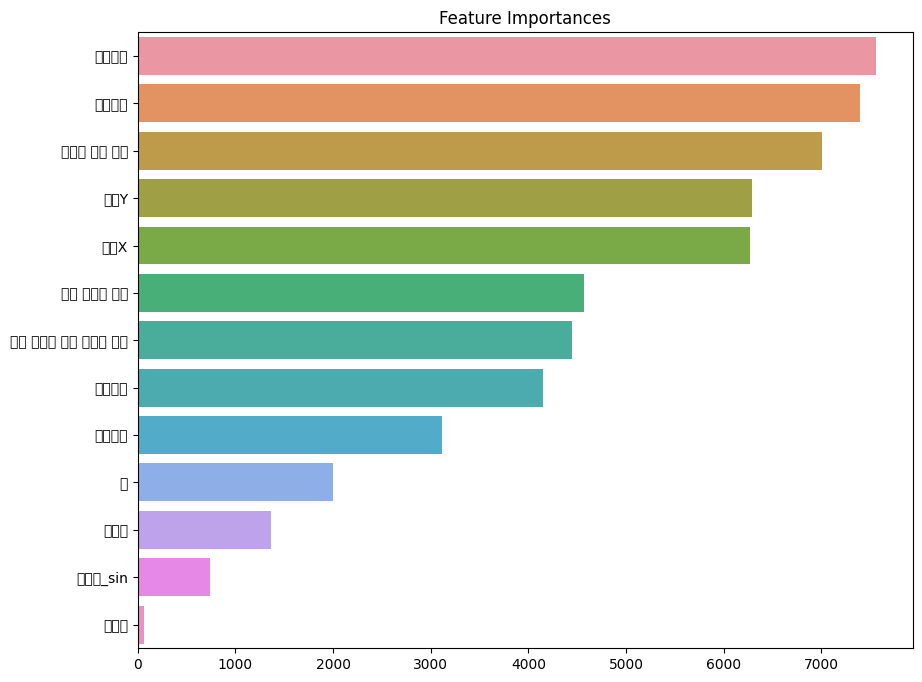

In [43]:
importances = pd.Series(model.feature_importances_, index=list(train_X.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

# 예측

In [44]:
test_df.drop(['target'], axis=1, inplace=True)
preds = model.predict(test_df)

/tmp/ipykernel_654307/2800422466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['target'], axis=1, inplace=True)


In [45]:
preds = np.round(preds).astype(int)
preds

array([197434, 303579, 296552, ...,  86727,  71929,  72311])

In [46]:
preds_df = pd.DataFrame(preds, columns=['target'])
preds_df

,target
0,197434
1,303579
2,296552
3,255842
4,202778
...,...
9267,71459
9268,71883
9269,86727
9270,71929


In [ ]:
preds_df.to_csv('../수한님_v_4_아파트평균_valid_2023.csv', index=False)